In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [82]:
from sklearn import set_config
set_config(display="text")  

# 1. 결측치, 이상치, 의미없는 컬럼 처리
- 현재 가지고 있는 데이터에서는 이상치와 결측치가 없고 이상치라 하더라도 그 나라에 해당하는 정확한 값이기에 어떤 방식으로 처리하진 않았다.
- 우리 팀프로젝트에선 기대수명에 미치는 요소들을 분석하여 주어진 데이터를 토대로 기대 수명이 어떤 값이 나오는지 확인시켜주는 프로그램이다.
- 이를 바탕으로 필요없는 데이터 '나라명', '년도', '지역'은 제거하고 진행할 생각이다.

In [83]:
# 의미없는 컬럼 제거
data = pd.read_csv('./data/Life-Expectancy-Data-Averaged.csv')

columns_to_drop = ['Country', 'Region', 'Year']
data = data.drop(columns=columns_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Infant_deaths                179 non-null    float64
 1   Under_five_deaths            179 non-null    float64
 2   Adult_mortality              179 non-null    float64
 3   Alcohol_consumption          179 non-null    float64
 4   Hepatitis_B                  179 non-null    float64
 5   Measles                      179 non-null    float64
 6   BMI                          179 non-null    float64
 7   Polio                        179 non-null    float64
 8   Diphtheria                   179 non-null    float64
 9   Incidents_HIV                179 non-null    float64
 10  GDP_per_capita               179 non-null    float64
 11  Population_mln               179 non-null    float64
 12  Thinness_ten_nineteen_years  179 non-null    float64
 13  Thinness_five_nine_y

# 2. EDA

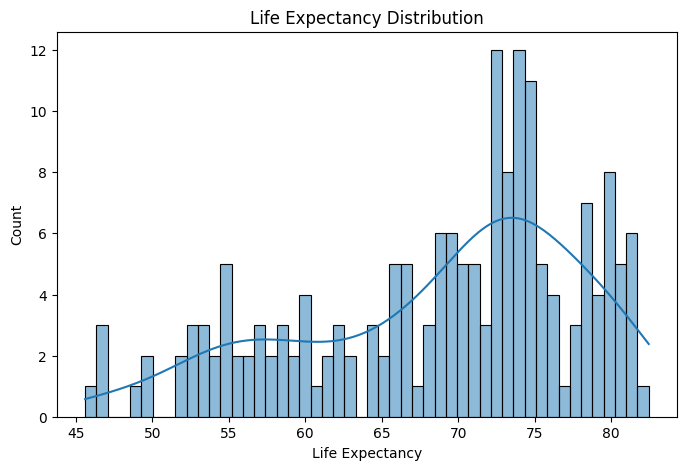

In [84]:
# Life_expectancy 분포 시각화
plt.figure(figsize=(8, 5))
sns.histplot(data['Life_expectancy'], bins=50, kde=True)
plt.title("Life Expectancy Distribution")
plt.xlabel("Life Expectancy")
plt.ylabel("Count")
plt.show()

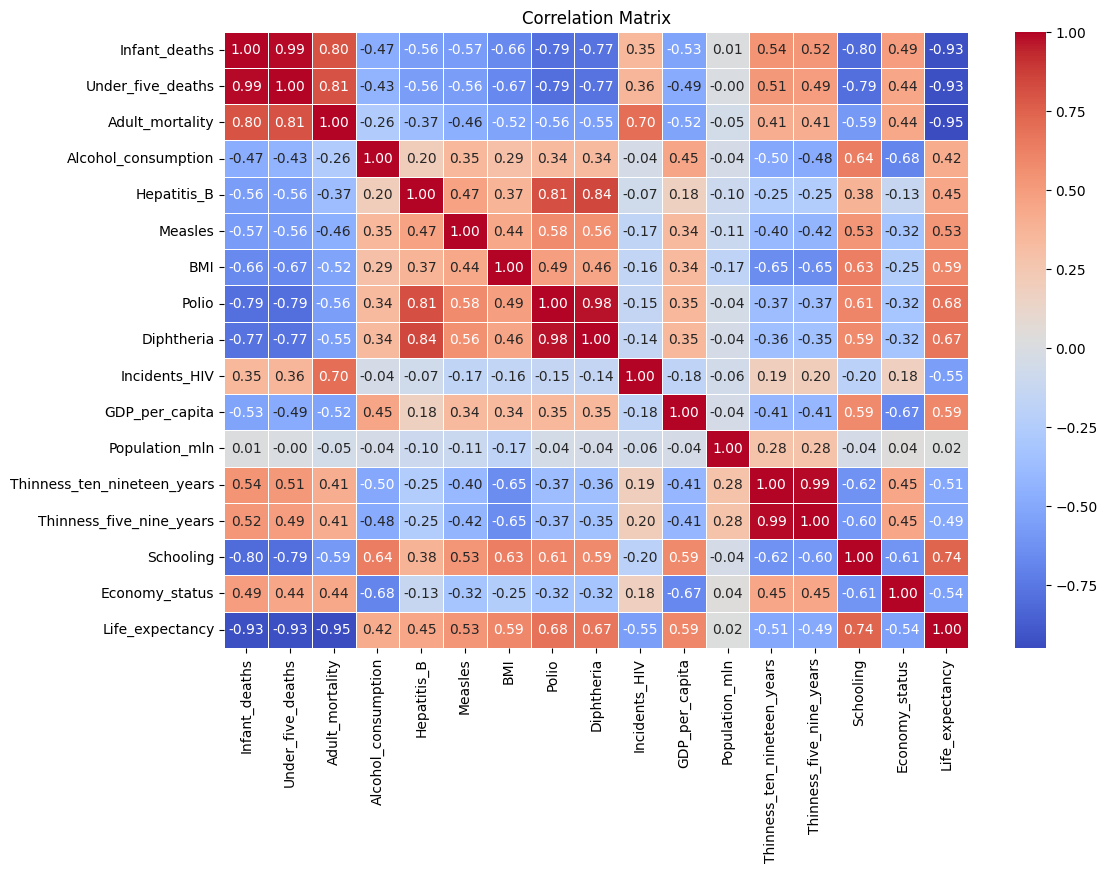

In [85]:
# 상관관계 분석 (Life_expectancy와 연관된 변수 찾기)
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

<img width=50% src="./images/heatmap_life_expectancy.png">

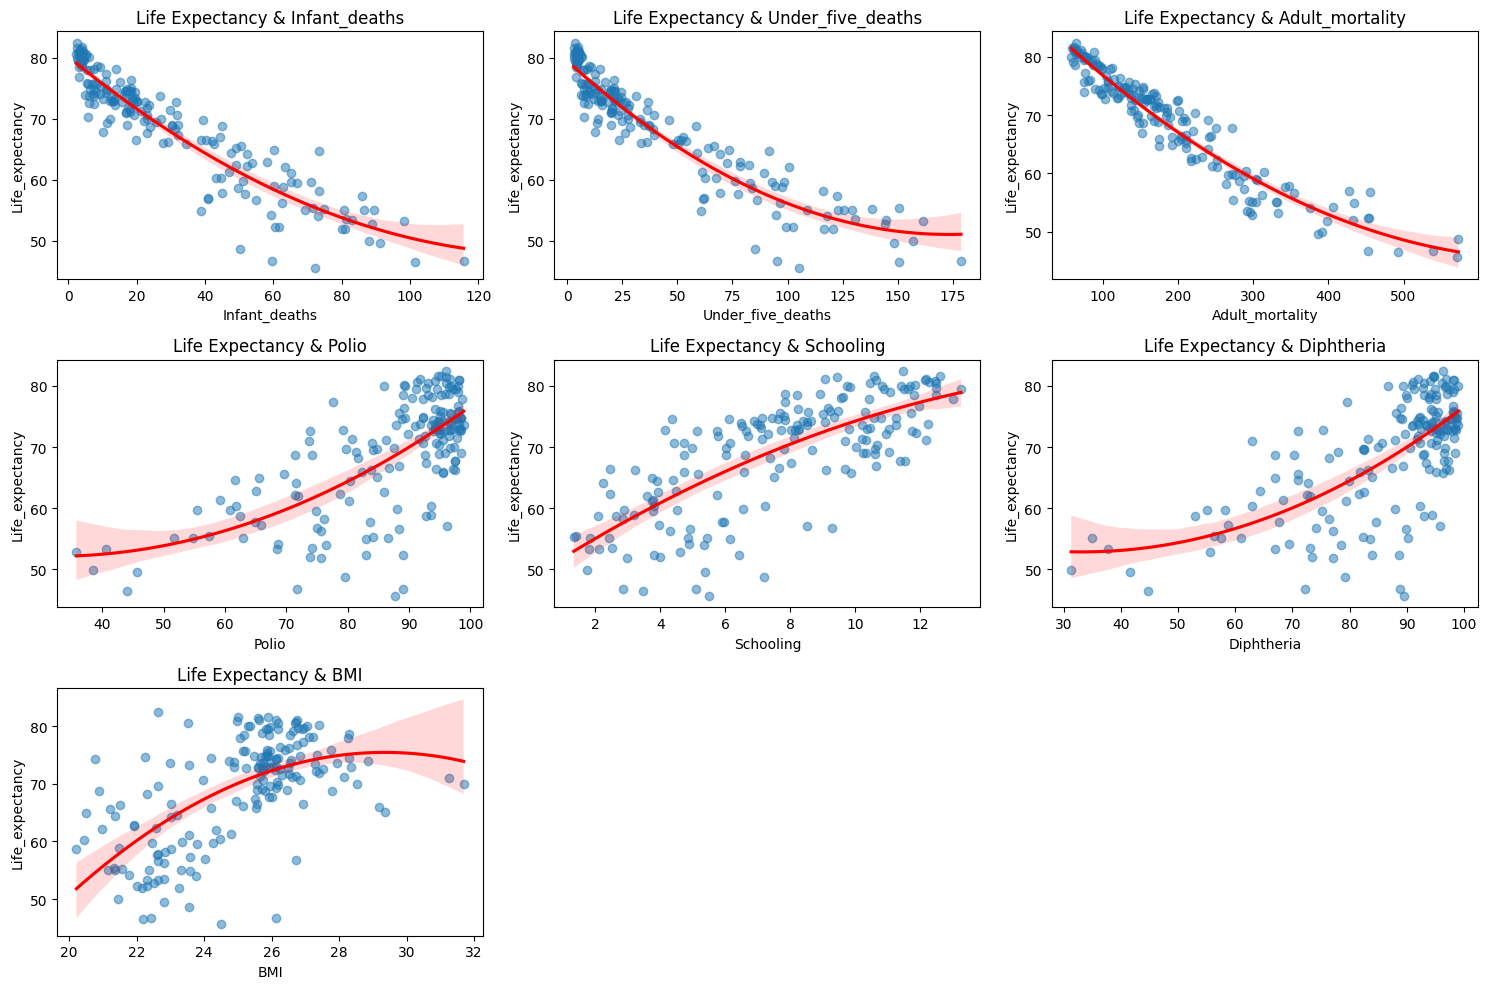

In [86]:
# 기대수명과 주요 변수 간 관계 시각화 (수치가 heatmap기준 절댓값 0.65이상인 변수만 파악)
important_features = ["Infant_deaths", "Under_five_deaths", "Adult_mortality", "Polio", "Schooling", "Diphtheria","BMI"]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(important_features, 1):
    plt.subplot(3, 3, i)
    sns.regplot(
        x=data[feature], 
        y=data['Life_expectancy'],
        order=2,
        scatter_kws={'alpha' : 0.5},
        line_kws={'color' : 'red'}
        )
    plt.title(f"Life Expectancy & {feature}")
plt.tight_layout()
plt.show()

### 결론
- 기대수명에 영향을 주는 요소들을 상관관계 프래프와 산포도를 통해 확인및 검증을 끝냈다.
- 이 데이터를 바탕으로 기본적으로 선형 & 다항회귀 방식을 통해 연속된 값에서 기대 수명을 출력해볼 생각
- 더 정확도를 올리기 위해서 후에 XGBoost, LioghtBoosing 회귀를 통해 정확도를 올려서 학습할 예정

# 3. 데이터 분할

In [87]:
# 특성과 타겟 데이터 분리
X = data.drop('Life_expectancy', axis=1)
y = data['Life_expectancy']

In [88]:
from sklearn.model_selection import train_test_split

X_train_add_es, X_test_add_es, y_train_add_es, y_test_add_es= train_test_split(
    X, y, test_size=0.2, random_state=42
)

economy_status = X["Economy_status"]  # Economy_status 따로 저장
X = X.drop(columns=["Economy_status"])  # 스케일링할 변수만 남김

X_train, X_test, y_train, y_test, economy_train, economy_test = train_test_split(
    X, y, economy_status, test_size=0.2, random_state=42
)


# 4. 정규화

In [89]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

X_train_final = np.hstack([X_train_scaled, economy_train.values.reshape(-1, 1)])  # economy_status 추가
X_test_final = np.hstack([X_test_scaled, economy_test.values.reshape(-1, 1)])  # economy_status 추가

X_train_final

array([[-0.63515015, -0.63846165, -0.19483306, ...,  0.9868774 ,
        -0.16616473,  1.        ],
       [ 2.69679021,  2.58228675,  2.68198571, ...,  0.58571992,
        -1.36624337,  1.        ],
       [ 0.56087025,  0.38114379, -0.40077627, ...,  2.3878188 ,
        -0.95185724,  1.        ],
       ...,
       [-0.92538886, -0.83319764,  0.26924387, ..., -0.59598426,
         0.99903982,  1.        ],
       [ 1.59269847,  1.49558238,  3.37966218, ...,  0.5810553 ,
        -0.69132735,  1.        ],
       [-0.91496396, -0.84736297, -1.20875767, ..., -1.00025149,
         0.70363585,  0.        ]])

# 5-1. 기본 선형회귀모델 학습

In [90]:
from sklearn.linear_model import LinearRegression

#모델 학습
li_reg = LinearRegression()
li_reg.fit(X_train_final,y_train)


LinearRegression()

# 6-1. 예측 및 평가

In [91]:
from sklearn.metrics import mean_squared_error             # MSE (평균 제곱 오차)
from sklearn.metrics import root_mean_squared_error        # RMSE (제곱 평균 제곱근 오차)
from sklearn.metrics import mean_absolute_error            # MAE (평균 절대 오차)
from sklearn.metrics import mean_squared_log_error         # MSLE (평균 제곱 로그 오차)
from sklearn.metrics import root_mean_squared_log_error    # RMSLE (제곱 평균 제곱근 로그 오차)
from sklearn.metrics import r2_score                       # R^2 결정계수

def evaluataion(y_true, y_pred):
    print('mse: ',mean_squared_error(y_true, y_pred))
    print('rmse: ',root_mean_squared_error(y_true, y_pred))
    print('mae: ', mean_absolute_error(y_true, y_pred))
    print('msle: ',mean_squared_log_error(y_true, y_pred))
    print('rmsle: ',root_mean_squared_log_error(y_true, y_pred))
    print('r2_score: ',r2_score(y_true, y_pred))
    
    plt.figure(figsize=(10, 5))

    # 산점도 그래프
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='red', label='Perfect Fit')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()

    # 잔차 시각화
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    mean_residuals = np.mean(residuals)
    std_residuals = np.std(residuals)

    # 히스토그램
    sns.histplot(residuals, bins=30, kde=True, color='green', edgecolor='black', alpha=0.7, stat="density", label="Residuals")
    sns.kdeplot(residuals, color='blue', linestyle='--', label='residuals_line')
    
    # 정규분포 곡선
    x_range = np.linspace(min(residuals), max(residuals), 100)
    plt.plot(x_range, norm.pdf(x_range, mean_residuals, std_residuals), color='red', linestyle='--', label="Normal Dist.")

    # plt.axvline(x=0, color='blue', linestyle='--', label="Zero Residual")
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title("Residual Distribution (with Normal Curve)")
    plt.legend()
    plt.tight_layout()
    plt.show()

mse:  1.1144170028882203
rmse:  1.0556595108690208
mae:  0.8211173801618119
msle:  0.0002498726333569981
rmsle:  0.015807360100820064
r2_score:  0.9875885250502774


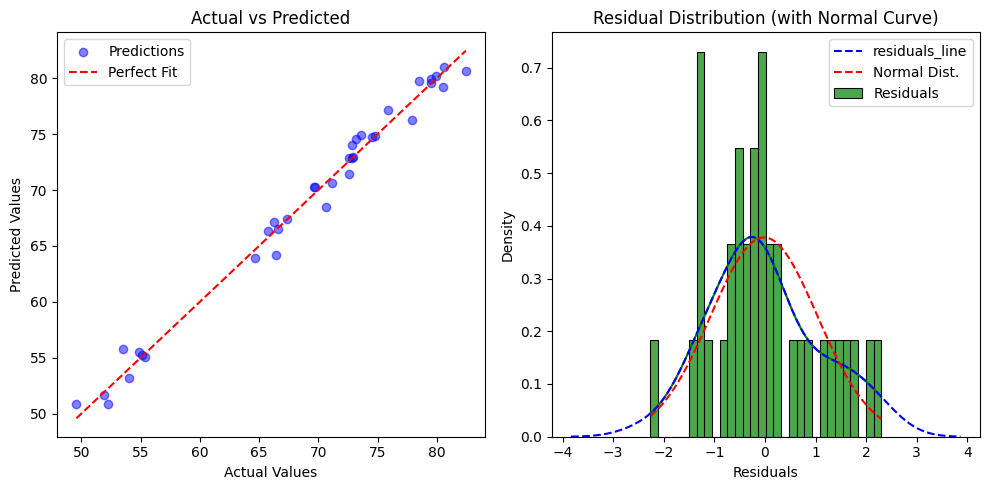

In [92]:
y_pred = li_reg.predict(X_test_final)
evaluataion(y_test,y_pred)


In [93]:
# 임의의 데이터로 예측 (2007년도 한국의 데이터 기대 수명: 79.16)
def input_predict(model):
    input_data = [3.5, 0.95677, 4.984, 9.48, 94.5, 96.4, 23.9, 86.3, 86.3, 0.8, 
                19730, 48.68, 5.85, 6.23, 11.36, 1]
    input_data_without_economy = input_data[:-1]
    input_array = np.array(input_data_without_economy, dtype=np.float32).reshape(1, -1)
    input_scaled = scaler.transform(input_array)

    # 스케일링된 데이터에 경제 상태 추가
    input_scaled_with_economy = np.append(input_scaled, input_data[-1]) 

    input_pred = model.predict(input_scaled_with_economy.reshape(1, -1))
    return input_pred

input_predict(li_reg)

c:\Users\ljh10\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([82.25581385])

# 7-1. 피드백
- 선형 모델을 학습한 결과 msle, rmsle가 0에 수렴하고 $r^2$가 0.95면 데이터 패턴을 잘 학습했다 평가 가능
- mse, rmse, mae 모두 나쁘지 않은 수치를 보여주고 있어 선형 회귀 모델만 사용해도 충분할것 같다는 생각
- 하지만 실측값을 통해 예측해본 결과 기대보다 원하는 값에 미치지 못함
### 다른 모델을 XGBOOST 사용해서 평가 예정

---

# 5-2. XGBoost 모델 학습

In [94]:
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

xgb_reg = XGBRegressor(   
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
    )

xgb_reg.fit(X_train_final,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# 6-2. 예측 및 평가

mse:  3.0000599922297027
rmse:  1.732068125747282
mae:  1.2926396263970266
msle:  0.0008680795132205229
rmsle:  0.029463189121690866
r2_score:  0.9665877590303072


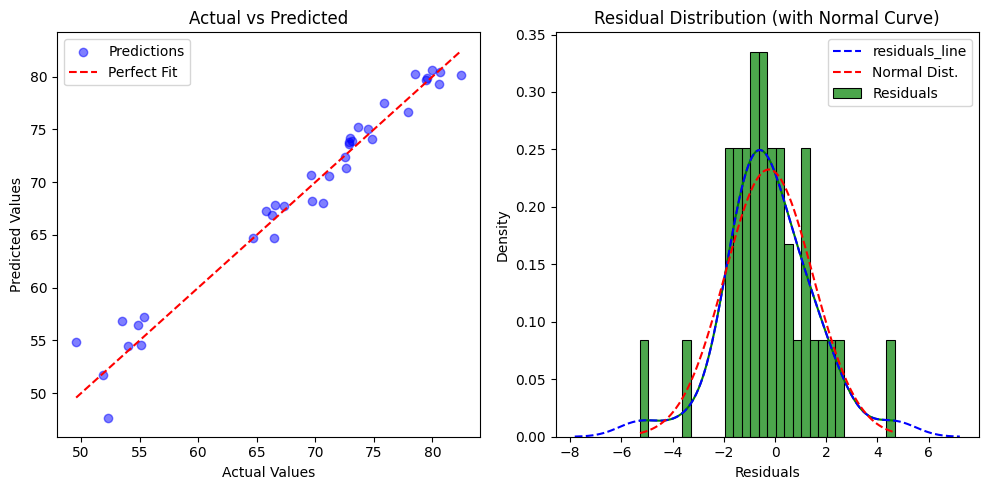

In [95]:
y_pred = xgb_reg.predict(X_test_final)
evaluataion(y_test,y_pred)

# fig,ax = plt.subplots(figsize=(10,12))
# plot_importance(xgb_reg,ax=ax)

# 7. 피드백
- 선형 회귀 모델보다 더 오차에 대해 안좋은 결과값이 나왔다.
- 하이퍼 파라미터 튜닝을 통해서 최적의 인자를 찾아보자

---

# 5-2-1. 하이퍼 파라미터 탐색

In [96]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200,300,500],
    'learning_rate': [0.01, 0.1, 0.2,0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.5,0.8, 1.0]
}
xgb_reg = XGBRegressor()
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,verbose=1, n_jobs=1,scoring='r2')
# grid_search.fit(X_train_final,y_train) # 한번만 하고 그만 
# print("최적의 파라미터:", grid_search.best_params_) # 컴퓨터가 아야해서 한번 찾아둔거 프린트 함수로 볼 예정
print('''최적의 파라미터: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.5}''')

최적의 파라미터: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.5}


# 5-2-2. XGBoost 모델 재학습

In [97]:
from xgboost.sklearn import XGBRegressor

xgb_reg = XGBRegressor(   
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    subsample=0.5
    )

xgb_reg.fit(X_train_final,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# 6-2-2. 모델 재평가

mse:  2.837227591729768
rmse:  1.6844071929702058
mae:  1.3110556284586588
msle:  0.0007623976909893691
rmsle:  0.027611549956302148
r2_score:  0.9684012545661528


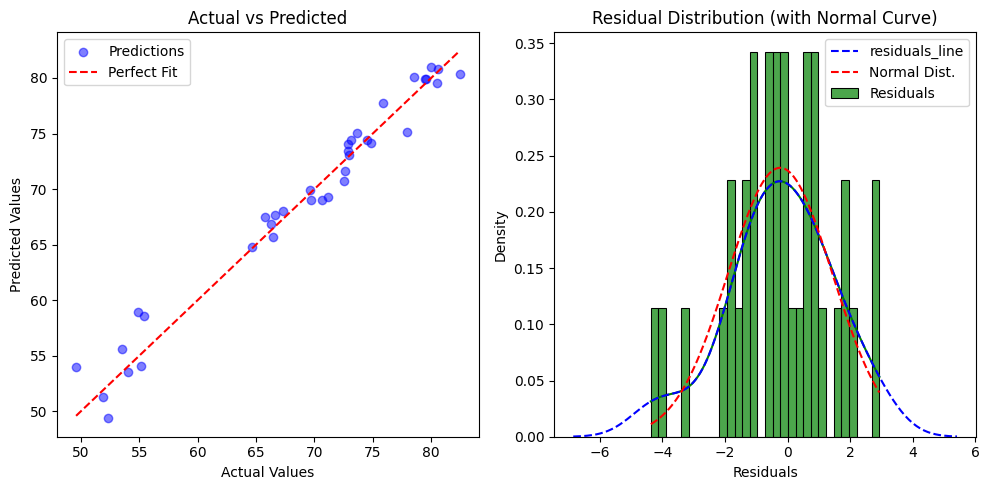

In [98]:
y_pred = xgb_reg.predict(X_test_final)
evaluataion(y_test,y_pred)

In [99]:
input_predict(xgb_reg)

c:\Users\ljh10\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([78.765236], dtype=float32)

# 7-2-2. 피드백
- 평가 값은 선형 회귀 모델에 비해 떨어지는걸 확인 가능하다. (그럼에도 여전히 좋은 평가 수치라 판단 가능)
- 하지만 반대로 실측값을 통한 예측은 오히려 더 오차 범위가 줄어든것을 확인할 수 있었다.